In [16]:
import pandas as pd
import matplotlib.pyplot as plt

Daten sind von: https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption?resource=download

In [4]:
filename = "data/Steel_industry_data.csv"

In [17]:
data=pd.read_csv(filename)
data;

<AxesSubplot:>

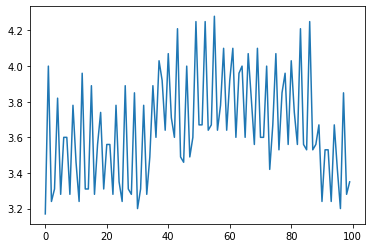

In [50]:
data.Usage_kWh[0:100].plot()

In [45]:
start = 1000
length = 100
data_differences = [data.Usage_kWh[start]]
for i in range(start,start+length):
    data_differences.append(data.Usage_kWh[i]- data_differences[i-1 - start])

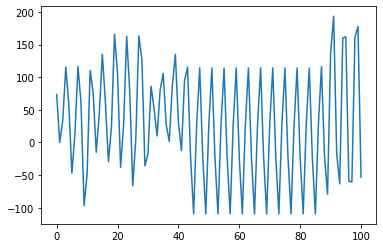

In [46]:
plt.plot(data_differences)

# Neuer Datensatz
Data from https://www.kaggle.com/datasets/jeanmidev/smart-meters-in-london

In [51]:
filename = "data/london_hourly/block_1.csv"

In [81]:
data=pd.read_csv(filename)
data_numeric=pd.to_numeric(data['energy(kWh/hh)'][0:10000])

<AxesSubplot:>

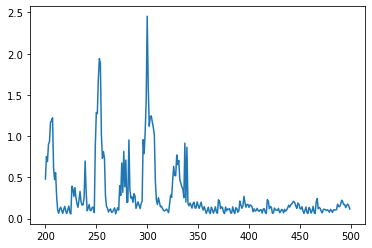

In [84]:
data_numeric[200:500].plot()

In [95]:
def plot_data(start, length):
    data_differences = [data_numeric[start]]
    for i in range(start,start+length):
        data_differences.append(data_numeric[i]- data_differences[i-1 - start])
    plt.plot(data_differences)

(None, None)

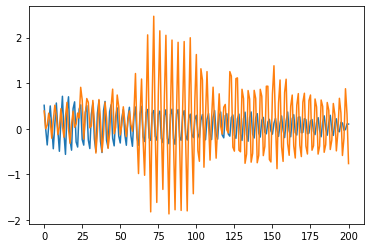

In [99]:
plot_data(1000,200), plot_data(2000,200)

(None, None)

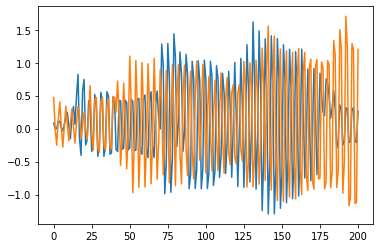

In [100]:
plot_data(3000,200), plot_data(4000,200)

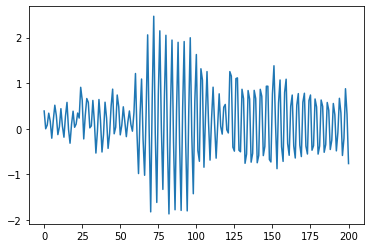

In [101]:
plot_data(2000,200)